## Calculate non-dimensional numbers for Barkley Canyon fitted profiles (Pathways Cruise)


In [69]:
from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from netCDF4 import Dataset

import numpy as np

import os

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

#lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout
import MetricsPythonTools as mpt


In [70]:
def scalingProfiles(L,Hs,dvC,dv2C,dhC,dh2C = 0.0):
    '''Calculates all non-dim numbers in the scaling scheme that depend on the profile characteristics.
    
    INPUT (values can be arrays or scalars, as long as they are the same size)
    
    L   : Length of the canyon
    Hs  : Depth of the shelf-break
    dvC : Initial vertical gradient of concentration
    dv2C: Initial vertical second derivative of concentration
    dhC : Initial horizontal gradient of concentration (in the direction of the canyon axis)
    dh2C: Initial horizontal second derivative of concentration (default is 0)
    
    OUTPUT
    
    Pi5,Pi6,Pi7 non-dim values as arrays if input values were arrays or scalars.
    
    '''
    
    if dhC == 0:
        Pi5 = (Hs * dv2C)/(dvC)
        Pi6 = (L * dhC) /(Hs * dvC)
        Pi7 = np.NaN
        
    else :
        Pi5 = (Hs * dv2C)/(dvC)
        Pi6 = (L * dhC) /(Hs * dvC)
        Pi7 = (Pi6 *L*dh2C)/dhC
    
    return Pi5,Pi6,Pi7

In [82]:
def scalingDynamics(kd,ki,N,L,Hs,f,Ush,W,Ffancy):
    '''Calculates all non-dim numbers in the scaling scheme related to N.
    
    INPUT (values can be arrays or scalars, as long as they are the same size)
    
    kd : vertical diffusivity
    ki : isopycnal diffusivity
    N  : Brunt-Vaisala frequancy
    L  : Length of the canyon
    Hs : Depth of the shelf-break
    f  : Coriolis parameter
    Ush: Speed upstream of the canyon
    W  : Width of canyon at 1/2 length
    Ffancy : 0.17 for Barkley
    
    OUTPUT
    
    Sv,Sh,Tv,Th non-dim values as arrays if input values were arrays or scalars.
    
    '''
    
    Rw = Ush/(f*W) # See H&A(2013), they say width at length scale works better than upstream curvature.
    
    #c2 = 0.9
    #c3 = 1.0
    #Ffancy = c3*(c2**(3.0/2))*(Rw/(1+(Rw/c2)))**(3.0/2) # See A&H(2010), Ffancy fitted from lab data. 
                                                        # They use Ro instead of Rw.
    
    Sv = kd / (N*Hs)
    Sh = ki / (N*L)
    Tv = (N**2 * Hs * L) / (Ffancy**(3./2) * Ush)
    Th = (N * L**(3./2)* np.sqrt(f)) / (Ffancy * np.sqrt(Ush))
    
    return Sv,Sh,Tv,Th 

See `Dropbox/UBC-RESEARCH/Data/NutrientProfilesFalkor.ipynb` for fitting process and data.

<img src="Figures/FittedCurves800m.png">
<img src="Figures/HorizontalProfiles200m.png">


In [72]:
# Fitted profiles for Falkor data

def S1(p):
    '''First 170 m of salinity profile'''
    profile = 1.7782E-2*p +(32.115*np.ones(np.shape(p))) 
    return profile

def S2(p):
    '''Under 170 m of salinity profile'''
    profile = 5.8233E-4*p +33.811*np.ones(np.shape(p)) 
    return profile

def O2(p):
    '''0 - 800 m of O2 profile'''
    profile = (2.2111E2*np.exp(-6.3637E-3*p)) + (np.ones(np.shape(p))*18.038)
    return profile

def NO3(p):
    '''0 - 800 m of NO3 profile'''
    profile = 8.2384*np.log(p) - (np.ones(np.shape(p))*8.9536)  
    return profile

def Si(p):
    '''0 - 400 m of Si profiles'''
    profile = 3.763*np.sqrt(p) + (np.ones(np.shape(p))*2.391) #0.09835*p + (np.ones(np.shape(p))*32.3222)
    return profile

def PO4(p):
    '''0 - 800 m of PO4 profile'''
    profile = p**(0.20431)  
    return profile

def differentiate_z(array,z):
    der = (array[2:]-array[0:-2])/(z[2:]-z[0:-2])
    return der

def differentiate_2x(array,z):
    der = (array[2:]-2*array[1:-1]+array[0:-2])/((z[2:]-z[1:-1])*(z[1:-1]-z[:-2]))
    return der

In [73]:
# Gradients Falkor profiles

dvAvg = np.zeros((7,1))
dv2Avg = np.zeros((7,1))

p1 = np.arange(0,110,10) 
p2 = np.arange(110,400,10)
p3 = np.arange(0,400,10) 

Sprof = np.append(S1(p1),S2(p2))
dvS = differentiate_z(Sprof,p3)
dv2S = differentiate_2x(Sprof,p3)
dvAvg[0] = np.mean(dvS[10:25])
dv2Avg[0] = np.mean(dv2S[10:25])

O2prof = O2(p3)
dvO2 = differentiate_z(O2prof,p3)
dvAvg[1] = np.mean(dvO2[10:25])
dv2O2 = differentiate_2x(O2prof,p3)
dv2Avg[1] = np.mean(dv2O2[10:25])

NO3prof = NO3(p3)
dvNO3 = differentiate_z(NO3prof,p3)
dvAvg[2]= np.mean(dvNO3[10:25])
dv2NO3 = differentiate_2x(NO3prof,p3)
dv2Avg[2] = np.mean(dv2NO3[10:25])

PO4prof = PO4(p3)
dvPO4 = differentiate_z(PO4prof,p3)
dvAvg[3] = np.mean(dvPO4[10:25])
dv2PO4 = differentiate_2x(PO4prof,p3)
dv2Avg[3] = np.mean(dv2PO4[10:25])

Siprof = Si(p3)
dvSi = differentiate_z(Siprof,p3)
dvAvg[4] = np.mean(dvSi[10:25])
dv2Si = differentiate_2x(Siprof,p3)
dv2Avg[4] = np.mean(dv2Si[10:25])



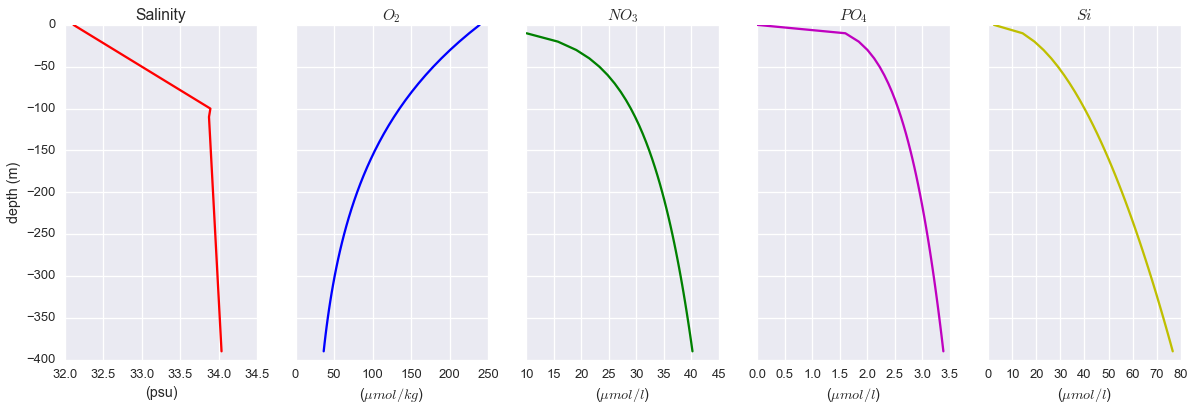

In [74]:
sns.set_context('talk')
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(20, 6), sharey=True)

ax1.plot(Sprof,-p3,'r')
ax1.set_title('Salinity')
ax1.set_ylabel('depth (m)')
ax1.set_xlabel('(psu)')

ax2.plot(O2prof,-p3,'b')
ax2.set_title('$O_2$')
ax2.set_xlabel('($\mu mol/kg$)')

ax3.plot(NO3prof,-p3,'g')
ax3.set_title('$NO_3$')
ax3.set_xlabel('($\mu mol/l$)')

ax4.plot(PO4prof,-p3,'m')
ax4.set_title('$PO_4$')
ax4.set_xlabel('($\mu mol/l$)')

ax5.plot(Siprof,-p3,'y')
ax5.set_title('$Si$')
ax5.set_xlabel('($\mu mol/l$)')


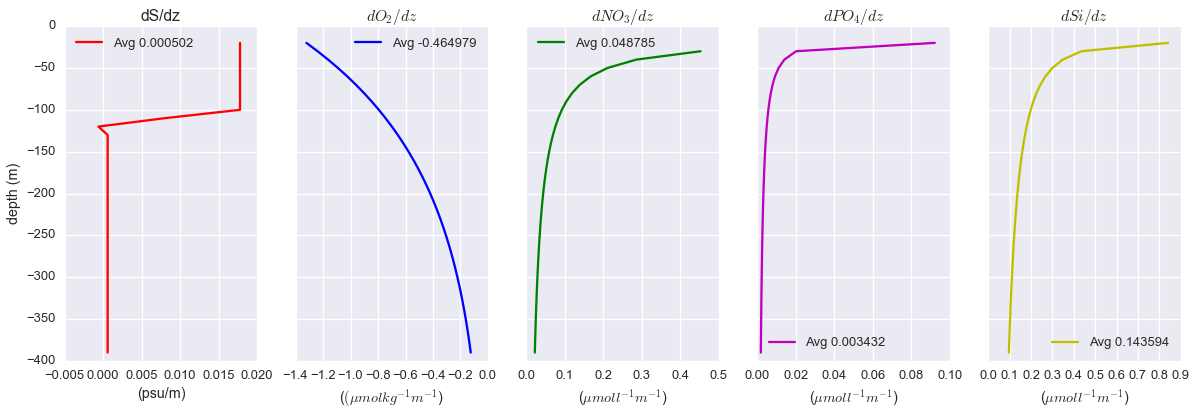

In [75]:
sns.set_context('talk')
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(20, 6), sharey=True)

ax1.plot(dvS,-p3[2:],'r',label = ('Avg %f' %dvAvg[0]))
ax1.set_title('dS/dz')
ax1.set_ylabel('depth (m)')
ax1.set_xlabel('(psu/m)')
ax1.legend(loc = 0)

ax2.plot(dvO2,-p3[2:],'b',label = ('Avg %f' %dvAvg[1]))
ax2.set_title('$dO_2/dz$')
ax2.set_xlabel('($(\mu mol kg^{-1} m^{-1}$)')
ax2.legend(loc = 0)

ax3.plot(dvNO3,-p3[2:],'g',label = ('Avg %f' %dvAvg[2]))
ax3.set_title('$dNO_3/dz$')
ax3.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax3.legend(loc = 0)

ax4.plot(dvPO4,-p3[2:],'m',label = ('Avg %f' %dvAvg[3]))
ax4.set_title('$dPO_4/dz$')
ax4.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax4.legend(loc = 0)

ax5.plot(dvSi,-p3[2:],'y',label = ('Avg %f' %dvAvg[4]))
ax5.set_title('$dSi/dz$')
ax5.set_xlabel('($\mu mol l^{-1} m^{-1}$)')
ax5.legend(loc = 0)

# OJO: average dC/dz from 100 m to 250 m (below mixed layer and above upwelling depth)


In [76]:
# Methane and nitrous acid - see notebook NutrientProfilesLineC2013.ipynb in /Data

#Methane
dvAvg[5] = np.mean([0.04662,0.06764])  #[conc]/m.  May and sep average 2013, so that it matches year of Pathways cruise
dv2Avg[5] = np.mean([-0.00387,-0.00778])

# Nitrous Acid
dvAvg[6] = np.mean([0.05230, 0.03289])
dv2Avg[6] = np.mean([-0.00477,-0.00911])


In [77]:
print(dvAvg)
print(dv2Avg)

[[ 0.00050244]
 [-0.46497882]
 [ 0.04878484]
 [ 0.00343163]
 [ 0.14359376]
 [ 0.05713   ]
 [ 0.042595  ]]
[[  1.59780000e-05]
 [  2.95798757e-03]
 [ -3.08058308e-04]
 [ -1.70165596e-05]
 [ -4.38919546e-04]
 [ -5.82500000e-03]
 [ -6.94000000e-03]]


In [83]:
kd = 3.9E-3
ki = 2.
N = 5.E-3
L = 6400.0
Hs = 200.0
f = 1.08E-4
Ush = 0.1
W = 8300.0
dhC = 0 # Change this later
Ffancy = 0.17

[Sv,Sh,Tv,Th] = scalingDynamics(kd,ki,N,L,Hs,f,Ush,W,Ffancy)
[Pi5,Pi6,Pi7] = scalingProfiles(L,Hs,dvAvg,dv2Avg,dhC,dh2C = 0.0)


In [84]:
Pi5 #Positive if both derivatives have same sign

array([[  6.36016241],
       [ -1.27231066],
       [ -1.26292641],
       [ -0.99174717],
       [ -0.61133511],
       [-20.39208822],
       [-32.58598427]])

$$S_v = \kappa_d / N Hs$$

$$S_h = \kappa_i / N L$$

$$T_v = N^2  Hs  L / \mathcal{F}^{3/2}  U$$

$$T_h = N L^{3/2} f^{1/2} / \mathcal{F}  U^{1/2}$$
   
$$\Pi_5=\Gamma = H_s \partial^2_vC/\partial_vC$$

In [86]:
print('Sv %s , Sh %s, Tv %s, Th %s' %(Sv,Sh,Tv,Th))

Sv 0.0039 , Sh 0.0625, Tv 4565.3764712721495, Th 494.883440193
